## `Ali Almalki` 

I am going to follow the following approach:

```
Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)
```

## What we're going to cover


* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions

In [3]:
# Check the GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-74699d0f-21d2-50be-22f1-a098c9addc0c)


## Get helper functions

In [4]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys 

--2022-06-24 19:44:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-24 19:44:05 (86.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Get a text dataset

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

#Unzip data 
unzip_data("nlp_getting_started.zip")

--2022-06-24 19:44:05--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.135.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.1’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2022-06-24 19:44:05 (40.8 MB/s) - ‘nlp_getting_started.zip.1’ saved [607343/607343]



In [6]:
# Standard scientific python imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import io
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import TextVectorization 
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from helper_functions import create_tensorboard_callback
from google.colab import files

## Become one with the data 😉

### Visualizing a text dataset

In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Check dataset shape (rows number, columns number)
train_df.shape

(7613, 5)

In [9]:
test_df.shape

(3263, 4)

In [10]:
test_df.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

In [11]:
# Check dataset columns names
train_df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [12]:
# Check dataset null values
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [13]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [15]:
# View a sample of the dataframe
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [16]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [17]:
# Shuffle the dataset
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [18]:
# How many examples of each class? Is the dataset balanced?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [19]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [20]:
# Visualize some random training examples 

random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row 
  print(f"Target: {target}", "Real Disaster!" if target > 0 else "Not real disaster")
  print(f"Text:\n {text}\n")
  print("---\n")


Target: 0 Not real disaster
Text:
 U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.co/x2Wn7O2a3w via @Change

---

Target: 1 Real Disaster!
Text:
 #Australia #News ; #Japan marks 70th anniversary of #Hiroshima atomic bombing  http://t.co/7aD0L7cgee READ MORE; http://t.co/hHzQl9tzNP

---

Target: 1 Real Disaster!
Text:
 Came across this fire video not mine..enjoy..#fire #firemen #firetruck #emergency #rescue #911 #summertime #sirensÛ_ http://t.co/hcYAJsAcfJ

---

Target: 0 Not real disaster
Text:
 New post: 'People are finally panicking about cable TV' http://t.co/pkfV8lkSlD

---

Target: 0 Not real disaster
Text:
 @ellenfromnowon 7-speed nexus shifter å£9! (For community cargo bike?) http://t.co/rjPjBwVfck

---



### Split data into training and validation 

In [21]:
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [22]:
train_tweets, val_tweets, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                      train_df_shuffled["target"].to_numpy(),
                                                                      test_size=0.2,# Use 20% of training data for validation split 
                                                                      random_state=42)


In [23]:
len(train_tweets), len(train_labels), len(val_tweets), len(val_labels)

(6090, 6090, 1523, 1523)

In [24]:
# Check the first 10 samples
train_tweets[:10], train_labels[:10]

(array(['Detonation fashionable mountaineering electronic watch water-resistant couples leisure tab\x89Û_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm',
        "Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo",
        'I-77 Mile Marker 31 to 40 South Mooresville  Iredell Vehicle Accident Congestion at 8/6 1:18 PM',
        "#Greece's tax revenues collapse as debt crisis continues via @guardian #bailout http://t.co/cJvbQXw83s ^mp",
        'Be not afraid of sudden fear neither of the desolation of the wicked when it cometh. For the Lord shall be thy... http://t.co/bP597YDs2b',
        'Storm batters Auckland and Northland: A violent overnight storm has battered Auckland and Northland uprooting... http://t.co/enrPGRgtTs',
        "Benzema increasingly looks to be a casualty of Benitez's new look squad. Arsenal bound? 50-50 chance I think",
        'Acquire your postexistence straight a elevation in addition

In [25]:
# Check the first two samples
train_tweets[:2], train_labels[:2]

(array(['Detonation fashionable mountaineering electronic watch water-resistant couples leisure tab\x89Û_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm',
        "Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo"],
       dtype=object), array([0, 1]))

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenziation - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [26]:
train_tweets[:5]

array(['Detonation fashionable mountaineering electronic watch water-resistant couples leisure tab\x89Û_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm',
       "Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo",
       'I-77 Mile Marker 31 to 40 South Mooresville  Iredell Vehicle Accident Congestion at 8/6 1:18 PM',
       "#Greece's tax revenues collapse as debt crisis continues via @guardian #bailout http://t.co/cJvbQXw83s ^mp",
       'Be not afraid of sudden fear neither of the desolation of the wicked when it cometh. For the Lord shall be thy... http://t.co/bP597YDs2b'],
      dtype=object)

In [27]:
# # Use the default TextVectorization parameters
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=None, # how many words in the vocabulary (automatically add <OOV>)
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None, # create groups of n-words?
    output_mode='int', # how to map tokens to numbers
    output_sequence_length=None,  # how long do you want your sequences to be?
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
)

In [28]:
print(train_tweets[0].split())
print(len(train_tweets[0].split()))

['Detonation', 'fashionable', 'mountaineering', 'electronic', 'watch', 'water-resistant', 'couples', 'leisure', 'tab\x89Û_', 'http://t.co/E61x9Y65QD', 'http://t.co/OVLET0gDqm']
11


In [29]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_tweets])/len(train_tweets))

15

In [30]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [31]:
text_vectorizer

To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [32]:
train_tweets[:10], train_labels[:10]

(array(['Detonation fashionable mountaineering electronic watch water-resistant couples leisure tab\x89Û_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm',
        "Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo",
        'I-77 Mile Marker 31 to 40 South Mooresville  Iredell Vehicle Accident Congestion at 8/6 1:18 PM',
        "#Greece's tax revenues collapse as debt crisis continues via @guardian #bailout http://t.co/cJvbQXw83s ^mp",
        'Be not afraid of sudden fear neither of the desolation of the wicked when it cometh. For the Lord shall be thy... http://t.co/bP597YDs2b',
        'Storm batters Auckland and Northland: A violent overnight storm has battered Auckland and Northland uprooting... http://t.co/enrPGRgtTs',
        "Benzema increasingly looks to be a casualty of Benitez's new look squad. Arsenal bound? 50-50 chance I think",
        'Acquire your postexistence straight a elevation in addition

In [33]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_tweets)

Training data mapped! Let's try our `text_vectorizer` on a custom sentence (one similar to what you might see in the training data).

In [34]:
max_length

15

In [35]:
# Create sample tweet and tokenize it
sample_tweet = "There is a heavy flood in Jeddah city this morning!"
text_vectorizer([sample_tweet])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  75,    9,    3,  911,  229,    4,    1,  178,   19, 1089,    0,
           0,    0,    0,    0]])>

Wonderful, it seems we've got a way to turn our text into numbers (in this case, word-level tokenization). Notice the 0's at the end of the returned tensor, this is because we set `output_sequence_length=15`, meaning no matter the size of the sequence we pass to `text_vectorizer`, it always returns a sequence with a length of 15.

How about we try our `text_vectorizer` on a few random sentences?

In [36]:
# Choose a random tweet from the training dataset and tokenize it
random_tweet = random.choice(train_tweets)
print(f"Original tweet:\n{random_tweet}\
      \n\nVectorized version:")
text_vectorizer([random_tweet])


Original tweet:
@kakajambori ??
U control the future of india..
Yor Subject: Exploration or seismic Maintenance( Electrical or Mechanical)      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1,  144,  710,    2, 1102,    6,  565, 6037, 2109, 1542,   53,
         649, 3381, 2296,   53]])>

We can also check the unique tokens in our vocabulary using the `get_vocabulary()` method.

In [37]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # Get all of the unique words in our training data


In [38]:
# Get the most common words 
words_in_vocab[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

In [39]:
# How many words in our vocabulary
len(words_in_vocab)

10000

In [40]:
# Get the most common words
top_5_words = words_in_vocab[:5]
top_5_words


['', '[UNK]', 'the', 'a', 'in']

In [41]:
# Get the least common words
bottom_5_words = words_in_vocab[-5:]
bottom_5_words

['minded', 'mindblowing', 'milne', 'milledgeville', 'millcityio']

In [42]:
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['minded', 'mindblowing', 'milne', 'milledgeville', 'millcityio']


### Creating an Embedding using an Embedding Layer

We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. `1` = I, `2` = love, `3` = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer. 

The main parameters we're concerned about here are:
* `input_dim` - The size of the vocabulary (e.g. `len(text_vectorizer.get_vocabulary()`).
* `output_dim` - The size of the output embedding vector, for example, a value of `100` outputs a  feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is `"uniform"` which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

Knowing these, let's make an embedding layer.

In [43]:
# Check 
max_vocab_length, max_length

(10000, 15)

In [44]:
# Create a TensorFlow Embedding Layer
embedding = layers.Embedding(input_dim=max_vocab_length, # input shape
                             output_dim=128, # output shape (preferably a number that is divisable by 8. e.g. 128/8=16.0,32/8=4.0)
                             embeddings_initializer="uniform",
                             input_length=max_length) # how long is each input
embedding                  

Notice how `embedding` is a TensoFlow layer? This is important because we can use it as part of a model, meaning its parameters (word representations) can be updated and improved as the model learns.

How about we try it out on a sample sentence?

In [45]:
# Get a random tweet from training tweets
random_tweet = random.choice(train_tweets)
print(f"Original tweet:\n{random_tweet}\
      \n\nEmbedded version:")

# Embed the random tweet (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_tweet]))
sample_embed

Original tweet:
@realDonaldTrump @rushlimbaugh ITS PROOF democrats are AFRAID of TRUMP clintons are trying to DERAIL TRUMP w the meddling      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03357576, -0.04285913, -0.01324692, ...,  0.02696728,
         -0.01788583, -0.03925152],
        [-0.03965668, -0.04484088, -0.04756632, ...,  0.00536186,
          0.00892211,  0.03149856],
        [ 0.04895807,  0.00195414,  0.0107785 , ..., -0.02606229,
         -0.03510846,  0.01732546],
        ...,
        [ 0.02610311,  0.0108101 ,  0.01243619, ..., -0.03203014,
          0.04385457, -0.03038381],
        [ 0.03364075, -0.01980685, -0.04977756, ...,  0.02731914,
         -0.03775548, -0.01697035],
        [-0.03872652, -0.04050428,  0.03231746, ..., -0.00349262,
          0.03875412, -0.04788325]]], dtype=float32)>

Each token in the tweet gets turned into a length 128 feature vector. <br>
(sequence(tweet), number of tokens, embedding dense (feature) vector) -> (1, 15, 128)

In [46]:
# Check out a single token's embedding
# print(len(sample_embed))
print(sample_embed[0][0])
print(type(sample_embed))
print(sample_embed[0][0].shape)
print(random_tweet)

tf.Tensor(
[-3.3575762e-02 -4.2859126e-02 -1.3246916e-02  4.3210816e-02
 -1.9061936e-02 -4.8610188e-02  4.8494115e-03  3.4679901e-02
 -4.5913674e-02 -1.6068388e-02  3.1485930e-03 -4.8934676e-02
 -4.4084977e-02  1.5522864e-02  3.3222709e-02 -3.3385206e-02
  1.3866138e-02 -2.5048554e-02 -2.6491094e-02  3.5127830e-02
 -3.6635436e-02  8.5345134e-03  2.5046732e-02  4.5277178e-05
 -2.9780556e-02 -1.0865651e-02 -2.7764952e-02  4.6789441e-02
 -8.2088336e-03  2.5851261e-02  2.5108580e-02  2.4150338e-02
 -2.1766722e-02 -1.0205794e-02 -4.2318858e-02  7.7698231e-03
  1.1627018e-02  3.5646927e-02 -4.8173595e-02  4.4220518e-02
 -4.8165727e-02 -2.6103426e-02  2.2661183e-02 -3.6939010e-03
  1.3419140e-02  3.0530158e-02 -8.6037517e-03 -1.1929870e-02
 -1.0515559e-02  3.4868494e-03 -8.1526861e-03  3.8221207e-02
  2.4061572e-02  1.5500393e-02 -2.9015386e-02 -3.1355396e-03
 -2.8113771e-02  1.7419171e-02 -3.9762665e-02  2.1500979e-02
 -5.5388436e-03  2.9364314e-02  3.7956905e-02  3.9619040e-02
  4.4786248e-

# Modelling Part
We'll be running a series of experiemnts:
* **Model 0**: Naive Bayes (baseline)
* **Model 1**: Feed-forward neural network (dense model)
* **Model 2**: LSTM model
* **Model 3**: GRU model
* **Model 4**: Bidirectional-LSTM model
* **Model 5**: 1D Convolutional Neural Network
* **Model 6**: TensorFlow Hub Pretrained Feature Extractor
* **Model 7**: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:
* Construct the model
* Train the model
* Make predictions with the model
* Track prediction evaluation metrics for later comparison


### **Model 0**: Naive Bayes (baseline)

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).


In [47]:
# 1. Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()), # convert words into numbers using tf-idf
                    ("clf", MultinomialNB()) # model the text
])

# 2. Fit the Pipeline to the training data 
model_0.fit(train_tweets, train_labels)

# 3. Evaluate our baseline model performance
baseline_score = model_0.score(val_tweets, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}% ")


Our baseline model achieves an accuracy of: 79.91% 


In [48]:
# Make predictions 
baseline_preds = model_0.predict(val_tweets)

# Check out the first 30 predictions
baseline_preds[:30]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0])

### Creating an evaluation function for our model experiments

A helper function which takes an array of predictions and ground truth labels and computes the following:
* Accuracy
* Precision
* Recall
* F1-score

In [49]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy":model_accuracy,
                   "precision":model_precision,
                   "recall":model_recall,
                   "f1":model_f1}
  return model_results


In [50]:
# Get baseline model results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 0.799080761654629,
 'f1': 0.7920155324845473,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629}

### **Model 1**: Feed-forward neural network (dense model)

In [51]:
# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs" 


In [52]:
# Check out text vectorizer and embeddings layers
print(text_vectorizer)
print(embedding)

In [53]:
# Build model with the Functional API
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional string
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding 
outputs = layers.Dense(1, activation="sigmoid") (x) # create the output layer, want binary outputs (disaster or not a disaster) so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model


In [54]:
# Get model summary 
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [55]:
# Compile the model 
model_1.compile(loss="binary_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
# Fit the model 
model_1_history = model_1.fit(train_tweets, # input tweets can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=10,
                              validation_data=(val_tweets, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220624-194414
Epoch 1/10
191/191 [==============================] - 5s 5ms/step - loss: 0.6200 - accuracy: 0.6816 - val_loss: 0.5461 - val_accuracy: 0.7557
Epoch 2/10
191/191 [==============================] - 1s 5ms/step - loss: 0.4517 - accuracy: 0.8143 - val_loss: 0.4759 - val_accuracy: 0.7807
Epoch 3/10
191/191 [==============================] - 1s 5ms/step - loss: 0.3511 - accuracy: 0.8603 - val_loss: 0.4620 - val_accuracy: 0.7879
Epoch 4/10
191/191 [==============================] - 1s 4ms/step - loss: 0.2854 - accuracy: 0.8923 - val_loss: 0.4662 - val_accuracy: 0.7945
Epoch 5/10
191/191 [==============================] - 1s 5ms/step - loss: 0.2358 - accuracy: 0.9141 - val_loss: 0.4776 - val_accuracy: 0.7859
Epoch 6/10
191/191 [==============================] - 1s 5ms/step - loss: 0.1971 - accuracy: 0.9325 - val_loss: 0.5024 - val_accuracy: 0.7814
Epoch 7/10
191/191 [==============================] - 1s 5ms/step - loss: 

In [57]:
# Check the results 
model_1.evaluate(val_tweets, val_labels)

48/48 [==============================] - 0s 3ms/step - loss: 0.5993 - accuracy: 0.7840


[0.5992710590362549, 0.7839789986610413]

In [58]:
# Make predictions with model_1
model_1_pred_probs = model_1.predict(val_tweets)
print(model_1_pred_probs[0],"\n") # Look at a single prediciton
print(model_1_pred_probs[:10]) # Look at the first 10 predictions
print(model_1_pred_probs.shape)

[0.5594832] 

[[0.5594832 ]
 [0.9162675 ]
 [0.9994741 ]
 [0.02932342]
 [0.00919162]
 [0.9869997 ]
 [0.9808187 ]
 [0.99960524]
 [0.99403507]
 [0.39084953]]
(1523, 1)


In [59]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [60]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

#### Compare baseline and model_1 preformance

In [61]:
model_1_results = calculate_results(y_true=val_labels,
                                     y_pred=model_1_preds)
model_1_results

{'accuracy': 0.7839789888378201,
 'f1': 0.7820472307448497,
 'precision': 0.7840406266090455,
 'recall': 0.7839789888378201}

In [62]:
baseline_results

{'accuracy': 0.799080761654629,
 'f1': 0.7920155324845473,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629}

In [63]:
# Compare models performance
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

# Visualizing learned embeddings

Let's visualize the word embeddings, to do so, we'll get the weights matrix (embedding matrix) from our embedding layer and visualize it using the Embedding project tool.

In [64]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:20]

(10000,
 ['',
  '[UNK]',
  'the',
  'a',
  'in',
  'to',
  'of',
  'and',
  'i',
  'is',
  'for',
  'on',
  'you',
  'my',
  'with',
  'it',
  'that',
  'at',
  'by',
  'this'])

In [65]:
# Model_1 Summary 
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [67]:
# Get the weight matrix of embedding layer
# (the weights are the numerical patterns between the text in the training dataset that the model has learned)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights)
print(embed_weights.shape)

[[ 0.03503445  0.03089445 -0.02294346 ... -0.06962352  0.04722873
   0.01647759]
 [ 0.00952813  0.01654835  0.01296494 ... -0.04324798  0.04800655
   0.04732879]
 [ 0.04489195 -0.01714419  0.01141796 ...  0.02653235  0.03703734
   0.00552984]
 ...
 [-0.04550081  0.02392579  0.03057669 ... -0.09083466  0.0697969
   0.09938256]
 [ 0.03357466 -0.00519176 -0.07548806 ...  0.02773649 -0.00681324
   0.01076705]
 [ 0.07573131 -0.10759249 -0.11426631 ...  0.04348827 -0.05224377
  -0.05535935]]
(10000, 128)


In [68]:
embedding.weights

[<tf.Variable 'embedding/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.03503445,  0.03089445, -0.02294346, ..., -0.06962352,
          0.04722873,  0.01647759],
        [ 0.00952813,  0.01654835,  0.01296494, ..., -0.04324798,
          0.04800655,  0.04732879],
        [ 0.04489195, -0.01714419,  0.01141796, ...,  0.02653235,
          0.03703734,  0.00552984],
        ...,
        [-0.04550081,  0.02392579,  0.03057669, ..., -0.09083466,
          0.0697969 ,  0.09938256],
        [ 0.03357466, -0.00519176, -0.07548806, ...,  0.02773649,
         -0.00681324,  0.01076705],
        [ 0.07573131, -0.10759249, -0.11426631, ...,  0.04348827,
         -0.05224377, -0.05535935]], dtype=float32)>]

In [69]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [70]:
# Code to save trained embeddings to file - Got this from here: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [71]:
# Let's download the saved embeddings locally
try:
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Model 2**: LSTM model

In [72]:
# Create an LSTM model 
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x)
# print(x.shape)
x = layers.LSTM(units=64)(x)
#print(x.shape)
# x = layers.Dense(units=64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [73]:
# Model_2_LSTM Summary 
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [74]:

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [75]:
# Fit model
history_2 = model_2.fit(train_tweets,
                        train_labels,
                        epochs=10,
                        validation_data=(val_tweets, val_labels),
                        callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                               experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220624-194511
Epoch 1/10
191/191 [==============================] - 6s 9ms/step - loss: 0.1381 - accuracy: 0.9557 - val_loss: 0.7283 - val_accuracy: 0.7754
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0794 - accuracy: 0.9709 - val_loss: 0.7351 - val_accuracy: 0.7656
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0668 - accuracy: 0.9726 - val_loss: 0.9205 - val_accuracy: 0.7754
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0602 - accuracy: 0.9745 - val_loss: 1.0536 - val_accuracy: 0.7754
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0543 - accuracy: 0.9782 - val_loss: 1.0633 - val_accuracy: 0.7702
Epoch 6/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0461 - accuracy: 0.9793 - val_loss: 1.0381 - val_accuracy: 0.7768
Epoch 7/10
191/191 [==============================] - 1s 7ms/step - loss: 0

In [76]:
# Make predictions with model_2_LSTM model
model_2_preds_probs = model_2.predict(val_tweets)
model_2_preds_probs[:10]

array([[3.1878814e-01],
       [5.2339268e-01],
       [9.9987030e-01],
       [2.0660834e-04],
       [7.8842466e-05],
       [9.9961191e-01],
       [9.9348748e-01],
       [9.9994910e-01],
       [9.9991465e-01],
       [9.9911135e-01]], dtype=float32)

In [77]:
# Convert model_2 predictions probabilities to label format 
model_2_preds = tf.squeeze(tf.round(model_2_preds_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [78]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [79]:
# Calculate model_2_LSTM results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7715036112934996,
 'f1': 0.7709308534287584,
 'precision': 0.7708136173868189,
 'recall': 0.7715036112934996}

In [80]:
baseline_results

{'accuracy': 0.799080761654629,
 'f1': 0.7920155324845473,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629}

### **Model 3**: GRU model

In [81]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, activation="tanh", return_sequences=True)(x) # return_sequences=True is required for stacking recurrent cells
# print(x.shape)
x = layers.GRU(64, activation="tanh")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [82]:
# Model_3 Summary 
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [83]:
# Compile the model 
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [84]:
# Fit model
model_3_history = model_3.fit(train_tweets,
                              train_labels,
                              epochs=10,
                              validation_data=(val_tweets, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220624-194535
Epoch 1/10
191/191 [==============================] - 3s 8ms/step - loss: 0.1283 - accuracy: 0.9486 - val_loss: 0.9443 - val_accuracy: 0.7741
Epoch 2/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0522 - accuracy: 0.9808 - val_loss: 0.9078 - val_accuracy: 0.7636
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0487 - accuracy: 0.9790 - val_loss: 1.1299 - val_accuracy: 0.7702
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0373 - accuracy: 0.9816 - val_loss: 1.3096 - val_accuracy: 0.7610
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0412 - accuracy: 0.9814 - val_loss: 1.2483 - val_accuracy: 0.7708
Epoch 6/10
191/191 [==============================] - 1s 6ms/step - loss: 0.0320 - accuracy: 0.9826 - val_loss: 1.5608 - val_accuracy: 0.7538
Epoch 7/10
191/191 [==============================] - 1s 6ms/step - loss: 0.

In [85]:
# Make predictions with model_3
model_3_pred_probs = model_3.predict(val_tweets)
model_3_pred_probs[:10], model_3_pred_probs.shape

(array([[5.7061136e-01],
        [8.5234457e-01],
        [9.9992585e-01],
        [2.5233752e-04],
        [7.6386619e-05],
        [9.9989903e-01],
        [9.9875033e-01],
        [9.9995422e-01],
        [9.9992239e-01],
        [9.9930155e-01]], dtype=float32), (1523, 1))

In [86]:
# Convert model_3 pred probs into label format
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [87]:
val_labels[:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0])

In [88]:
# Calculate results for model_3
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 0.7655942219304005,
 'f1': 0.7656139383186525,
 'precision': 0.7656343187690227,
 'recall': 0.7655942219304005}

In [89]:
baseline_results

{'accuracy': 0.799080761654629,
 'f1': 0.7920155324845473,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629}

### **Model 4**: Bidirectional RNN Model

In [90]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # return_sequences=True required for stacking RNN layers
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [91]:
# Get Model_4 Summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [92]:
# Compile model_4
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [93]:
# Fit model_4
history_model_4 = model_4.fit(train_tweets,
                              train_labels,
                              epochs=10,
                              validation_data=(val_tweets, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220624-194550
Epoch 1/10
191/191 [==============================] - 5s 12ms/step - loss: 0.0886 - accuracy: 0.9773 - val_loss: 1.0384 - val_accuracy: 0.7538
Epoch 2/10
191/191 [==============================] - 2s 8ms/step - loss: 0.0345 - accuracy: 0.9842 - val_loss: 1.3094 - val_accuracy: 0.7538
Epoch 3/10
191/191 [==============================] - 2s 8ms/step - loss: 0.0339 - accuracy: 0.9851 - val_loss: 1.3872 - val_accuracy: 0.7544
Epoch 4/10
191/191 [==============================] - 2s 8ms/step - loss: 0.0289 - accuracy: 0.9844 - val_loss: 1.4993 - val_accuracy: 0.7603
Epoch 5/10
191/191 [==============================] - 2s 8ms/step - loss: 0.0323 - accuracy: 0.9837 - val_loss: 1.3767 - val_accuracy: 0.7636
Epoch 6/10
191/191 [==============================] - 2s 8ms/step - loss: 0.0358 - accuracy: 0.9834 - val_loss: 1.3675 - val_accuracy: 0.7584
Epoch 7/10
191/191 [==============================] - 2s 9ms/step

In [94]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_tweets)
model_4_pred_probs[:10], model_4_pred_probs.shape

(array([[2.2444312e-02],
        [6.7909038e-01],
        [9.9997890e-01],
        [3.4534368e-03],
        [2.8160746e-05],
        [9.9996245e-01],
        [9.9882334e-01],
        [9.9999225e-01],
        [9.9994898e-01],
        [9.9963164e-01]], dtype=float32), (1523, 1))

In [95]:

type(val_labels)

numpy.ndarray

In [96]:
# Convert pred probs to label format
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10], val_labels[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>,
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [97]:
# Calculate model 4 results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 0.7642810242941562,
 'f1': 0.7636125683497123,
 'precision': 0.7635056752409535,
 'recall': 0.7642810242941562}

### **Model 5**: 1D Convolutional Neural Network

In [98]:
# Let's do a little test to see what things look like through the eyes of a Conv1D layer
embedding_test = embedding(text_vectorizer(["My name is Ali Almalki"])) # turn target sentence into embedding


In [99]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03484831,  0.07891946,  0.03130705, ..., -0.07721213,
          0.07679687,  0.04936841],
        [-0.17366818,  0.10822959,  0.12564838, ..., -0.06190975,
          0.18643695,  0.09927509],
        [-0.03236427, -0.0015175 ,  0.00573264, ..., -0.06320584,
          0.02763166,  0.0475626 ],
        ...,
        [ 0.01229935,  0.02393961, -0.00995475, ..., -0.05394716,
          0.03966745,  0.02072157],
        [ 0.01229935,  0.02393961, -0.00995475, ..., -0.05394716,
          0.03966745,  0.02072157],
        [ 0.01229935,  0.02393961, -0.00995475, ..., -0.05394716,
          0.03966745,  0.02072157]]], dtype=float32)>

In [100]:
conv_1d_layer = layers.Conv1D(filters=32,
                              kernel_size=5, # setting this to 5 means it'll look at 5 words at a time, 3 would mean 3 words at a time
                              activation="relu",
                              padding="valid")
conv_1d_output = conv_1d_layer(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)
print(f"Embedding output shape: {embedding_test.shape}")
print(f"Conv1D output shape: {conv_1d_output.shape}")
print(f"Max pool output shape: {max_pool_output.shape}")

Embedding output shape: (1, 15, 128)
Conv1D output shape: (1, 11, 32)
Max pool output shape: (1, 32)


In [101]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.00000000e+00, 1.12998299e-01, 0.00000000e+00, 2.80982871e-02,
         1.40327573e-01, 0.00000000e+00, 1.16329163e-01, 0.00000000e+00,
         7.76921748e-04, 2.29687572e-01, 7.26132244e-02, 0.00000000e+00,
         9.70416144e-03, 0.00000000e+00, 2.01344088e-01, 6.18348196e-02,
         0.00000000e+00, 9.47650075e-02, 3.36462036e-02, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.03146100e-01, 0.00000000e+00, 0.00000000e+00,
         8.96556675e-02, 2.25196540e-01, 0.00000000e+00, 1.84596270e-01],
        [0.00000000e+00, 7.90804774e-02, 0.00000000e+00, 1.15980357e-01,
         0.00000000e+00, 0.00000000e+00, 2.08787978e-01, 4.45160717e-02,
         0.00000000e+00, 1.05603814e-01, 0.00000000e+00, 1.42181646e-02,
         0.00000000e+00, 0.00000000e+00, 7.86727443e-02, 9.88077819e-02,
         0.00000000e+00, 3.24571393e-02, 7.47762769e-02, 2.67003179e-0

In [102]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1 ,activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

In [103]:
# Get model_5 summary 
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 output_layer (Dense)        (None, 1)              

In [104]:
# Set batch size to be 32 
BATCH_SIZE = 32

In [105]:
# Compile model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [106]:
# Fit the model
history_model_5 = model_5.fit(train_tweets,
                              train_labels,
                              epochs=10,
                              batch_size=BATCH_SIZE,
                              validation_data=(val_tweets, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20220624-194616
Epoch 1/10
191/191 [==============================] - 3s 8ms/step - loss: 0.0957 - accuracy: 0.9709 - val_loss: 0.9743 - val_accuracy: 0.7669
Epoch 2/10
191/191 [==============================] - 2s 9ms/step - loss: 0.0535 - accuracy: 0.9813 - val_loss: 1.1072 - val_accuracy: 0.7636
Epoch 3/10
191/191 [==============================] - 2s 8ms/step - loss: 0.0479 - accuracy: 0.9800 - val_loss: 1.2851 - val_accuracy: 0.7643
Epoch 4/10
191/191 [==============================] - 1s 7ms/step - loss: 0.0450 - accuracy: 0.9810 - val_loss: 1.2985 - val_accuracy: 0.7695
Epoch 5/10
191/191 [==============================] - 1s 5ms/step - loss: 0.0432 - accuracy: 0.9805 - val_loss: 1.2725 - val_accuracy: 0.7564
Epoch 6/10
191/191 [==============================] - 1s 5ms/step - loss: 0.0406 - accuracy: 0.9824 - val_loss: 1.2626 - val_accuracy: 0.7577
Epoch 7/10
191/191 [==============================] - 1s 5ms/step - loss:

In [107]:
# Make predictions with our 1D CNN
model_5_pred_probs = model_5.predict(val_tweets)
model_5_pred_probs[:5], model_5_pred_probs.shape

(array([[9.1451305e-01],
        [9.4349027e-01],
        [9.9999702e-01],
        [1.1713248e-03],
        [8.4589789e-07]], dtype=float32), (1523, 1))

In [108]:
# Convert model 5 pred probs to label format 
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10], val_labels[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>,
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [109]:
# Calculate results for model 5
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 0.7518056467498359,
 'f1': 0.7518878055526148,
 'precision': 0.7519803839588943,
 'recall': 0.7518056467498359}

In [110]:
baseline_results

{'accuracy': 0.799080761654629,
 'f1': 0.7920155324845473,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629}

### Try to improve model_5 Conv1D

In [111]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1 ,activation="relu")(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1 ,activation="relu")(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1 ,activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
model_5_improved = tf.keras.Model(inputs, outputs, name="model_5_conv1d")

In [112]:
# Get model summary 
model_5_improved.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 64)             20544     
                                                                 
 conv1d_4 (Conv1D)           (None, 3, 64)             20544     
                                                    

In [113]:
# Set batch size to be 32 
BATCH_SIZE = 32

In [114]:
# Compile model
model_5_improved.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [115]:
# Fit the model
history_model_5_improved = model_5_improved.fit(train_tweets,
                              train_labels,
                              epochs=50,
                              batch_size=BATCH_SIZE,
                              validation_data=(val_tweets, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_conv1d_improved")])

Saving TensorBoard log files to: model_logs/model_5_conv1d_improved/20220624-194631
Epoch 1/50
191/191 [==============================] - 2s 8ms/step - loss: 0.0885 - accuracy: 0.9662 - val_loss: 1.1375 - val_accuracy: 0.7531
Epoch 2/50
191/191 [==============================] - 1s 6ms/step - loss: 0.0409 - accuracy: 0.9814 - val_loss: 1.6107 - val_accuracy: 0.7610
Epoch 3/50
191/191 [==============================] - 2s 9ms/step - loss: 0.0333 - accuracy: 0.9831 - val_loss: 1.7373 - val_accuracy: 0.7617
Epoch 4/50
191/191 [==============================] - 2s 10ms/step - loss: 0.0304 - accuracy: 0.9831 - val_loss: 1.8281 - val_accuracy: 0.7571
Epoch 5/50
191/191 [==============================] - 2s 10ms/step - loss: 0.0285 - accuracy: 0.9841 - val_loss: 1.9226 - val_accuracy: 0.7498
Epoch 6/50
191/191 [==============================] - 2s 9ms/step - loss: 0.0280 - accuracy: 0.9852 - val_loss: 2.1810 - val_accuracy: 0.7452
Epoch 7/50
191/191 [==============================] - 1s 6ms/s

In [116]:
# Make predictions with our improved 1D CNN 
model_5_improved_pred_probs = model_5_improved.predict(val_tweets)
model_5_improved_pred_probs[:5], model_5_improved_pred_probs.shape

(array([[4.1224223e-02],
        [9.8807400e-01],
        [1.0000000e+00],
        [1.5698951e-07],
        [1.2972199e-15]], dtype=float32), (1523, 1))

In [117]:
# Convert model 5 improved pred probs to label format
model_5_improved_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_improved_preds[:10], val_labels[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>,
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [118]:
# Calculate results for model 5
model_5_improved_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_improved_preds)
model_5_improved_results

{'accuracy': 0.7518056467498359,
 'f1': 0.7518878055526148,
 'precision': 0.7519803839588943,
 'recall': 0.7518056467498359}

In [119]:
baseline_results

{'accuracy': 0.799080761654629,
 'f1': 0.7920155324845473,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629}

### **Model 6**: TensorFlow Hub Pretrained Feature Extractor

In [120]:
# Load USE pre-trained embedding layer 
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [121]:
sample_sentence = "This is a sample sentence"

In [122]:
embed_samples = embed([sample_sentence,
                       "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[ 0.02977698 -0.00973895  0.00557957  0.02802082 -0.06812037  0.00998993
  0.0533644   0.06521872  0.00836992  0.02471027 -0.03885113  0.00238559
 -0.04320041  0.06734677 -0.01469686 -0.07557523 -0.02528279 -0.00998903
 -0.03554086 -0.03333504  0.03651324  0.0555104  -0.02342965  0.06534462
 -0.06750899  0.07081413 -0.00211465 -0.07342657  0.03833517 -0.04406539
  0.02539304 -0.00729961 -0.02637325 -0.03199447 -0.09696697  0.0014572
  0.00869264  0.00793812 -0.05916344  0.00559159 -0.02367862  0.03981502
 -0.03100172  0.06804526 -0.04422791  0.00125464  0.05244232 -0.01462981
  0.04709483 -0.00095289], shape=(50,), dtype=float32)


In [123]:
embed_samples.shape

TensorShape([2, 512])

In [124]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # Any input length can go into this embedding layer
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [125]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")                               
], name="model_6_USE")



In [126]:
# Compile model_6
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [127]:
# Get model_6 summary 
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [128]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_tweets,
                              train_labels,
                              epochs=10,
                              validation_data=(val_tweets, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220624-194816
Epoch 1/10
191/191 [==============================] - 5s 15ms/step - loss: 0.5125 - accuracy: 0.7828 - val_loss: 0.4486 - val_accuracy: 0.7958
Epoch 2/10
191/191 [==============================] - 3s 13ms/step - loss: 0.4139 - accuracy: 0.8158 - val_loss: 0.4420 - val_accuracy: 0.7978
Epoch 3/10
191/191 [==============================] - 3s 13ms/step - loss: 0.3979 - accuracy: 0.8241 - val_loss: 0.4405 - val_accuracy: 0.7997
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3897 - accuracy: 0.8274 - val_loss: 0.4371 - val_accuracy: 0.8043
Epoch 5/10
191/191 [==============================] - 3s 13ms/step - loss: 0.3831 - accuracy: 0.8307 - val_loss: 0.4369 - val_accuracy: 0.8063
Epoch 6/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3779 - accuracy: 0.8338 - val_loss: 0.4367 - val_accuracy: 0.8050
Epoch 7/10
191/191 [==============================] - 3s 1

In [129]:
# Make predictions with model_6 USE TF Hub Model
model_6_pred_probs = model_6.predict(val_tweets)
model_6_pred_probs[:10]

array([[0.20928274],
       [0.81411994],
       [0.9947031 ],
       [0.12646978],
       [0.67640924],
       [0.788631  ],
       [0.98854464],
       [0.99007297],
       [0.9383287 ],
       [0.0823497 ]], dtype=float32)

In [130]:
# Convert prediction probabilities to label format
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10], val_labels[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>,
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [131]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 0.8154957321076822,
 'f1': 0.8137301795543065,
 'precision': 0.8165200610381643,
 'recall': 0.8154957321076822}

In [132]:
baseline_results

{'accuracy': 0.799080761654629,
 'f1': 0.7920155324845473,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629}

### **Model 7**: TF Hub Pretrained USE (same as model_6) with 10% of training data

In [133]:
len(train_tweets), type(train_tweets)

(6090, numpy.ndarray)

In [134]:
train_tweets[:2]

array(['Detonation fashionable mountaineering electronic watch water-resistant couples leisure tab\x89Û_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm',
       "Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo"],
      dtype=object)

##### NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
##### DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

In [135]:
# # Split the dataset with 10% training samples
# train_10_percent_split = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_tweets_10_percent = train_10_percent_split["text"].to_list()
# train_labels_10_percent = train_10_percent_split["target"].to_list()


In [136]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_tweets))
train_tweets_10_percent = train_tweets[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [137]:
len(train_tweets_10_percent), len(train_labels_10_percent)

(609, 609)

In [138]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    324
1    285
dtype: int64

In [139]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [140]:
# Create model_7 the same as in model_6
model_7 = tf.keras.models.clone_model(model_6)

In [141]:
# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [142]:
# Get model_7 summary 
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [143]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_tweets_10_percent,
                              train_labels_10_percent,
                              epochs=10,
                              validation_data=(val_tweets, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20220624-194905
Epoch 1/10
20/20 [==============================] - 4s 82ms/step - loss: 0.6762 - accuracy: 0.6453 - val_loss: 0.6544 - val_accuracy: 0.7636
Epoch 2/10
20/20 [==============================] - 1s 44ms/step - loss: 0.6211 - accuracy: 0.8194 - val_loss: 0.6068 - val_accuracy: 0.7761
Epoch 3/10
20/20 [==============================] - 1s 33ms/step - loss: 0.5584 - accuracy: 0.8177 - val_loss: 0.5545 - val_accuracy: 0.7754
Epoch 4/10
20/20 [==============================] - 1s 44ms/step - loss: 0.4969 - accuracy: 0.8276 - val_loss: 0.5162 - val_accuracy: 0.7722
Epoch 5/10
20/20 [==============================] - 1s 32ms/step - loss: 0.4509 - accuracy: 0.8342 - val_loss: 0.4987 - val_accuracy: 0.7689
Epoch 6/10
20/20 [==============================] - 1s 33ms/step - loss: 0.4182 - accuracy: 0.8374 - val_loss: 0.4854 - val_accuracy: 0.7807
Epoch 7/10
20/20 [===========================

In [144]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_tweets)
model_7_pred_probs[:10]

array([[0.270578  ],
       [0.93283546],
       [0.9446134 ],
       [0.5651035 ],
       [0.887375  ],
       [0.8572259 ],
       [0.96378994],
       [0.9620102 ],
       [0.9055945 ],
       [0.12781985]], dtype=float32)

In [145]:
# Turn pred probs into label format (ones and zeros)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10], val_labels[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 1., 1., 1., 1., 1., 1., 0.], dtype=float32)>,
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [146]:
# Evalaute model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 0.7669074195666448,
 'f1': 0.7675830722887758,
 'precision': 0.7695973214344519,
 'recall': 0.7669074195666448}

In [147]:
print(baseline_results)
print(model_6_results)
print(model_7_results)

{'accuracy': 0.799080761654629, 'precision': 0.8146358812834972, 'recall': 0.799080761654629, 'f1': 0.7920155324845473}
{'accuracy': 0.8154957321076822, 'precision': 0.8165200610381643, 'recall': 0.8154957321076822, 'f1': 0.8137301795543065}
{'accuracy': 0.7669074195666448, 'precision': 0.7695973214344519, 'recall': 0.7669074195666448, 'f1': 0.7675830722887758}


In [148]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.799081,0.814636,0.799081,0.792016
1_simple_dense,0.783979,0.784041,0.783979,0.782047
2_lstm,0.771504,0.770814,0.771504,0.770931
3_gru,0.765594,0.765634,0.765594,0.765614
4_bidirectional,0.764281,0.763506,0.764281,0.763613
5_conv1d,0.751806,0.751980,0.751806,0.751888
6_tf_hub_use_encoder,0.815496,0.816520,0.815496,0.813730
7_tf_hub_use_encoder_10_percent,0.766907,0.769597,0.766907,0.767583


In [149]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.799081,0.814636,0.799081,0.792016
1_simple_dense,0.783979,0.784041,0.783979,0.782047
2_lstm,0.771504,0.770814,0.771504,0.770931
3_gru,0.765594,0.765634,0.765594,0.765614
4_bidirectional,0.764281,0.763506,0.764281,0.763613
5_conv1d,0.751806,0.751980,0.751806,0.751888
6_tf_hub_use_encoder,0.815496,0.816520,0.815496,0.813730
7_tf_hub_use_encoder_10_percent,0.766907,0.769597,0.766907,0.767583


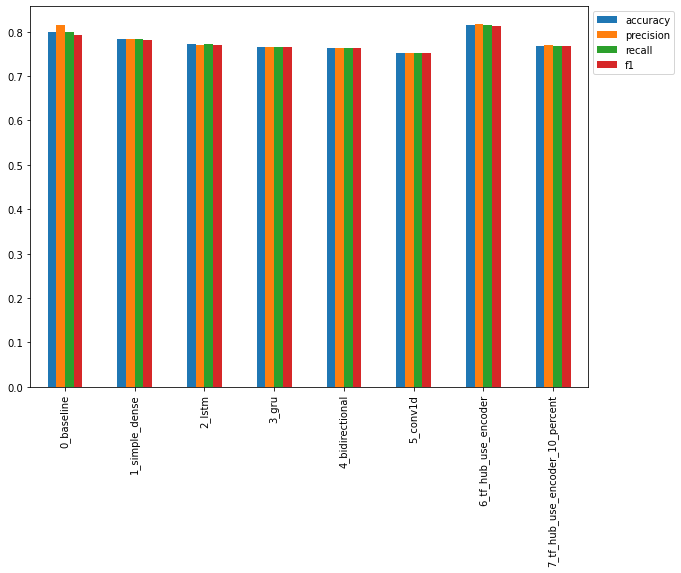

In [150]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

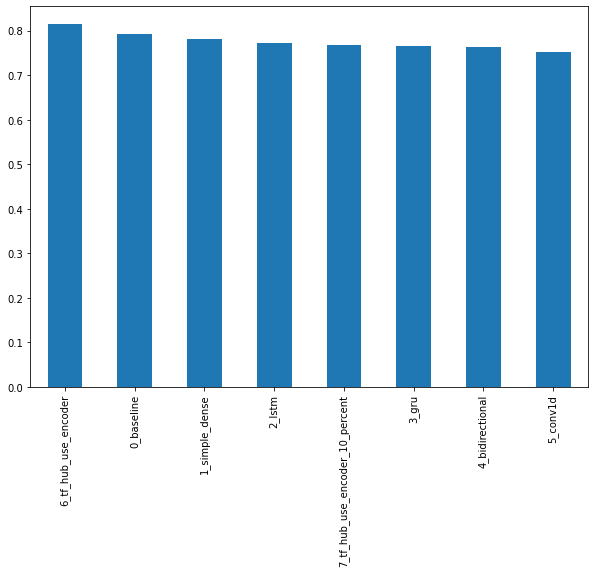

In [151]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

### Uploading our model training logs to `TesnorBoard.dev`

In [152]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models) and upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
--name "NLP Disaster Tweets Model Experiments" \
--description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
--one_shot # to exit the uploader once uploading is finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=4nHdyYq15644MeH3wfVvi2VUEaphOr&prompt=consent&access_type=offline

#### My modelling experiments are visable now on TensorBoard.dev:
https://tensorboard.dev/experiment/GVEiY42ZQQiyKBsOJnB95A/

In [154]:
# Check previous experiments saved on TensorBoard dev
!tensorboard dev list

https://tensorboard.dev/experiment/GVEiY42ZQQiyKBsOJnB95A/
	Name                 NLP Disaster Tweets Model Experiments
	Description          Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset
	Id                   GVEiY42ZQQiyKBsOJnB95A
	Created              2022-06-24 19:57:35 (7 minutes ago)
	Updated              2022-06-24 19:57:43 (6 minutes ago)
	Runs                 16
	Tags                 5
	Scalars              720
	Tensor bytes         0
	Binary object bytes  2961077
Total: 1 experiment(s)


In [ ]:
# To delete an experiment from TensorBoard, run the following command:
# !tensorboard dev delete --experiment_id Eacboed3RbKPWIGcXe1Z6gB

### Saving and loading model_6 (best model)


In [155]:
# Save the model in HDF5 format
model_6.save("model_6.h5")

In [156]:
# Load the model
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [158]:
# Evaluate model performance
loaded_model_6.evaluate(val_tweets, val_labels)

48/48 [==============================] - 2s 19ms/step - loss: 0.4347 - accuracy: 0.8155


[0.4346992075443268, 0.8154957294464111]

### References: 

* [TensorFlow Documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols)

* [Dataset - Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data)

* [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

* [Keras Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

* [Embedding Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

* [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

* [Tf–idf term weighting](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

* [Scikit-Learn Metrics and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html)

* [Global Average Pooling1D Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

* [Embedding Projector Tool in TensorFlow](https://www.tensorflow.org/tutorials/text/word_embeddings)

* [Embedding Projector](https://projector.tensorflow.org/)

* [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/#:~:text=The%20LSTM%20does%20have%20the,and%20a%20pointwise%20multiplication%20operation.)

* [MIT 6.S191: Recurrent Neural Networks](https://www.youtube.com/watch?v=SEnXr6v2ifU)


* [TensorFlow Bidirectional ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)

* [Conv1D Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)

* [USE - universal-sentence-encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

* [TensorFlow Model Clone](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model)

* [TensorBoard.dev](https://tensorboard.dev/)

* [Weights & Biases to track modelling experiments](https://wandb.ai/site)

* [Save and Load Models](https://www.tensorflow.org/tutorials/keras/save_and_load)













